# Music

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

In [3]:
import music21
from music21 import *
from IPython.display import Image, Audio

In [4]:
path = Path('data/composers/notewise/piano_solo/note_range62/sample_freq12')
path.ls()[:5]

[PosixPath('data/composers/notewise/piano_solo/note_range62/sample_freq12/jazz'),
 PosixPath('data/composers/notewise/piano_solo/note_range62/sample_freq12/ravel'),
 PosixPath('data/composers/notewise/piano_solo/note_range62/sample_freq12/bach'),
 PosixPath('data/composers/notewise/piano_solo/note_range62/sample_freq12/schumann'),
 PosixPath('data/composers/notewise/piano_solo/note_range62/sample_freq12/liszt')]

https://hpml2018.github.io/HPML2018_1.pdf

This paper suggests linear scaling rule does not work with RNNs. 3e-3 seems to be the magical number for 2k-8k

However, they didn't use schedule warmup, so I doubt they optimized the learning rate enough

In [5]:
bs=512
bptt=250

In [6]:
data = TextLMDataBunch.load(path, bs=bs, bptt=bptt)
t = data.train_ds[0][0]
t.text[:50], t.data

('xxbos wait25 wait25 wait25 wait25 wait25 wait25 wa',
 array([  2, 124, 124, 124, ...,   9, 105,   9, 157]))

In [7]:
out = data.one_batch(); out[0].shape

torch.Size([512, 275])

### Load Learner

In [8]:
learn = language_model_learner(data, drop_mult=1, clip=.2, bptt=bptt)

In [9]:
# https://devblogs.nvidia.com/mixed-precision-training-deep-neural-networks/ - nvidia used 128 
learn = learn.to_fp16()

In [10]:
# From old code
# learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)    # Applying regularization
# learner.clip=0.3                                          # Clip the gradients  

### Load second run from last notebook

In [11]:
learn.load('bs1024_lr6en3_run2');

1e-3 diverges first epoch
5e-5 also diverges on first epoch

In [12]:
learn.unfreeze()
learn.fit_one_cycle(12, 1e-6, moms=(0.7,0.5))

epoch,train_loss,valid_loss,accuracy
1,0.909951,0.968778,0.712085
2,0.907246,0.968937,0.712072
3,0.911594,0.968570,0.712057
4,0.900045,0.968047,0.712168
5,0.897034,0.967810,0.712207
6,0.905886,0.968272,0.712163
7,0.902153,0.968056,0.712173
8,0.908315,0.967418,0.712352
9,0.879908,0.973255,0.711202
10,0.883573,0.966803,0.712475


In [ ]:
learn.recorder.plot_lr()

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('bs1024_lr1en3_run3_bptt250');

## Done

In [15]:
out = learn.pred_batch()

In [16]:
learn.show_results(rows=5, max_len=25)

text,target,pred
xxbos wait24 p32 wait3 endp32 wait9 p16 p32 wait5 endp16 endp32 wait7 p18 p33 wait5 endp18 endp33 wait7 p20 p35 wait5 endp20 endp35 wait7 p20,wait8 endp20 endp35 wait4 p18 p33 wait5 endp18 endp33 wait19 p15 p30 wait5 endp15 endp30 wait7 p16 p32 wait5 endp16 endp32 wait7 p18 p33 wait5,wait3 endp20 endp35 wait4 p21 p33 wait5 endp18 endp33 wait7 p16 p30 wait8 endp15 endp30 wait7 p16 p32 wait5 endp16 endp32 wait7 p18 p33 wait5
endp23 endp30 wait1 p9 p11 wait5 endp9 wait1 p4 p7 p11 p16 wait6 p7 p11 p16 wait5 endp7 wait1 p11 p16 p19 wait5 endp16 endp19,p11 p18 p21 wait5 endp18 endp21 wait1 p4 p11 p16 p19 p23 wait5 endp11 endp19 endp23 wait1 p16 endp16 p18 endp18 p21 endp21 wait2 p16,p4 p15 p21 wait5 endp18 endp21 wait1 p11 p11 p16 p19 wait5 wait5 endp4 endp16 endp23 wait1 p4 p21 p18 endp18 p21 endp21 wait3 endp4
wait5 endp16 wait1 p14 wait5 endp19 wait1 p9 wait5 endp9 wait1 p19 wait5 endp14 wait1 p12 wait5 endp19 wait1 p17 wait5 endp17 wait1 p19 wait5,wait1 p11 wait5 endp19 wait1 p16 wait5 endp16 wait1 p19 wait5 endp11 wait1 p9 wait5 endp19 wait1 p14 wait5 endp14 wait1 p19 wait5 endp9 wait1,endp19 p11 wait5 endp11 wait1 p17 wait5 endp16 wait1 p17 wait5 endp11 endp19 p12 wait5 endp19 wait1 p17 wait5 endp14 wait1 p12 wait5 endp9 wait1
endp16 endp21 endp28 wait1 p19 p22 p24 wait5 endp19 endp22 wait1 p12 p18 p21 wait2 endp12 endp18 endp21 wait4 p12 p18 p21 wait2 endp12 endp18,wait4 p4 p12 wait2 endp4 endp12 wait4 p33 wait11 endp33 wait1 p18 p21 p24 wait2 endp18 endp21 wait4 p12 p17 p20 wait2 endp12 endp17 endp20,wait4 p12 p12 p19 endp4 endp12 wait4 p4 wait2 endp33 wait1 p12 p21 p24 wait2 endp18 endp21 endp24 p18 p18 wait2 wait2 endp12 endp17 endp20
endp8 wait1 p10 wait1 p11 wait1 endp10 wait1 endp11 p13 p19 endp19 p31 endp31 wait2 p11 endp13 wait1 p10 wait1 endp11 wait1 endp10 wait1 p8,endp20 p32 endp32 wait2 endp8 wait4 p3 p32 endp32 wait2 endp3 p5 wait1 p7 wait1 endp5 wait1 endp7 wait1 p8 p35 endp35 wait2 endp8 wait1,p32 wait2 endp32 wait2 endp8 wait1 p7 p31 endp32 wait2 endp3 wait1 wait1 p7 wait1 endp5 wait1 endp7 wait1 p8 wait2 wait2 wait2 endp8 wait1


In [40]:
idx = 12
folder_idx = 2 # 2 = bach
seed_len = 250

file = path.ls()[folder_idx].ls()[idx]
with open(file, 'r') as f:
    txt_out = f.read()
notes = txt_out.split(' ')
seed = ' '.join(notes[:seed_len])

note_offset = 45 if 'note_range38' in str(file) else 33
sample_freq = 12 if 'sample_freq12' in str(file) else 4

note_offset, sample_freq, file

(33,
 12,
 PosixPath('data/composers/notewise/piano_solo/note_range62/sample_freq12/bach/813_5bm2.txt'))

In [41]:
pred_out = learn.predict(seed, n_words=500)

### Testing

In [ ]:
seed

In [ ]:
pred_only = pred_out.replace(seed, '').strip(); pred_only

### Generate from predictions

In [44]:
from utils import *

In [53]:
pred_format = pred_out.replace('xxbos ', '')

In [54]:
note_stream = arrToStreamNotewise(pred_format.split(' '), sample_freq=sample_freq/2, note_offset=45)

In [55]:
note_stream

<music21.stream.Stream 0x7f6f1b5b1828>

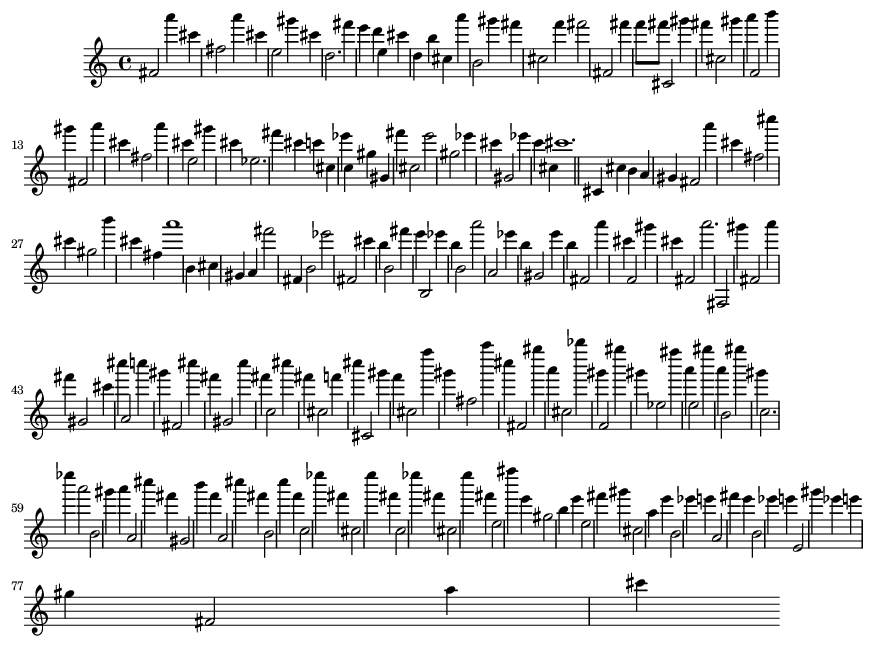

In [56]:
Image(filename=str(note_stream.write('lily.png')))

In [57]:
note_stream.show('midi')